# COVID-19 Data Analysis

In [49]:
from os import listdir
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
path='csse_covid_19_daily_reports'

files_names = [f for f in listdir(path) if f.endswith(".csv")]

# Date dictinary

In [3]:
all_data_dict = {file_name.split('.')[0]: pd.read_csv(path+"/"+file_name) for file_name in files_names}

dates_list = list(all_data_dict.keys())

## Cleaning

In [4]:
for date, data_df in all_data_dict.items():
    all_data_dict[date].loc[:,'Confirmed'].fillna(value=0, inplace=True)
    all_data_dict[date].loc[:,'Deaths'].fillna(value=0, inplace=True)
    all_data_dict[date].loc[:,'Recovered'].fillna(value=0, inplace=True)
    all_data_dict[date]=all_data_dict[date].astype({'Confirmed':'int64', 'Deaths':'int64', 'Recovered':'int64'})
    all_data_dict[date]=all_data_dict[date].replace({'Country/Region':'Mainland China'}, 'China')
    all_data_dict[date].rename(columns={'Last Update': 'LastUpdate'}, inplace=True)
    all_data_dict[date]['LastUpdate']= pd.to_datetime(all_data_dict[date]['LastUpdate'])
    all_data_dict[date]['Date']= pd.to_datetime(date)

In [5]:
all_data_dict[dates_list[0]].head()

,Province/State,Country/Region,LastUpdate,Confirmed,Deaths,Recovered,Date
0,Anhui,China,2020-01-22 17:00:00,1,0,0,2020-01-22
1,Beijing,China,2020-01-22 17:00:00,14,0,0,2020-01-22
2,Chongqing,China,2020-01-22 17:00:00,6,0,0,2020-01-22
3,Fujian,China,2020-01-22 17:00:00,1,0,0,2020-01-22
4,Gansu,China,2020-01-22 17:00:00,0,0,0,2020-01-22


In [6]:
all_data_dict[dates_list[0]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 7 columns):
Province/State    35 non-null object
Country/Region    38 non-null object
LastUpdate        38 non-null datetime64[ns]
Confirmed         38 non-null int64
Deaths            38 non-null int64
Recovered         38 non-null int64
Date              38 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(2)
memory usage: 2.2+ KB


# Country dictinary

In [7]:
if not os.path.exists('Countries_data'):
    os.makedirs('Countries_data')

all_country_dict={}
for Country in set(all_data_dict[dates_list[-1]]['Country/Region']): 

    df_country = pd.DataFrame(columns=['Confirmed', 'Recovered', 'Deaths', 'LastUpdate','Date'])

    for date, data_df in all_data_dict.items():
        if Country in list(data_df['Country/Region']):
            dfTpm = data_df.groupby(['Country/Region']).agg({'Confirmed':np.sum, 
                                                             'Recovered':np.sum, 
                                                             'Deaths':np.sum, 
                                                             'LastUpdate':'first',
                                                             'Date':'first'})
            
            df_country = df_country.append(dfTpm.loc[Country, :])        

    df_country=df_country.reset_index(drop=True)
    
    df_country['New_Confirmed']=df_country['Confirmed'].diff()
    df_country.at[0, 'New_Confirmed'] = df_country['Confirmed'][0]
    df_country['New_Deaths']=df_country['Deaths'].diff()
    df_country.at[0, 'New_Deaths'] = df_country['Deaths'][0]

    df_country = df_country.astype({'New_Confirmed':int, 'Confirmed':int, 'Deaths':int, 'Recovered':int, 'New_Deaths':int})
#     df_country.set_index(df_country['Date'], drop=True, inplace=True)
    all_country_dict[Country]= df_country
    df_country.to_csv('Countries_data/{}.csv'.format(Country), index = True)

In [8]:
country_list = list(all_country_dict.keys())
all_country_dict[country_list[0]].head()

,Confirmed,Recovered,Deaths,LastUpdate,Date,New_Confirmed,New_Deaths
0,1,0,0,2020-03-16 14:38:45,2020-03-16,1,0
1,1,0,0,2020-03-17 01:33:03,2020-03-17,0,0
2,3,0,0,2020-03-18 11:33:04,2020-03-18,2,0
3,6,0,0,2020-03-19 11:33:36,2020-03-19,3,0
4,6,0,0,2020-03-19 11:33:36,2020-03-20,0,0


In [9]:
all_country_dict[country_list[0]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 7 columns):
Confirmed        11 non-null int64
Recovered        11 non-null int64
Deaths           11 non-null int64
LastUpdate       11 non-null datetime64[ns]
Date             11 non-null datetime64[ns]
New_Confirmed    11 non-null int64
New_Deaths       11 non-null int64
dtypes: datetime64[ns](2), int64(5)
memory usage: 696.0 bytes


# World DataFrame

In [10]:
world_count=pd.DataFrame(columns=['Date', 'CountryCount','Confirmed', 'Recovered', 'Deaths'])
country= set()
for date, data_df in all_data_dict.items():
    for c in list(data_df['Country/Region'].unique()):
        country.add(c)
    world_count=world_count.append({'Date' : date , 
                                    'CountryCount' : len(country) ,
                                    'Confirmed' : data_df['Confirmed'].sum(), 
                                    'Recovered' : data_df['Recovered'].sum(), 
                                    'Deaths' : data_df['Deaths'].sum()} , ignore_index=True)
    
world_count['Date']=pd.to_datetime(world_count['Date']).dt.date
world_count["InTreatment"] = world_count.Confirmed - (world_count.Recovered + world_count.Deaths)
world_count['New_Confirmed']=world_count['Confirmed'].diff()
world_count.at[0, 'New_Confirmed'] = world_count['Confirmed'][0]
world_count['New_Deaths']=world_count['Deaths'].diff()
world_count.at[0, 'New_Deaths'] = world_count['Deaths'][0]
world_count= world_count.astype({'CountryCount':'int64','Confirmed':'int64' ,'Deaths':'int64', 'Recovered':'int64', 'New_Confirmed':'int64' ,'New_Deaths':'int64', 'InTreatment':'int64'})
world_count["MortalityRate"] = world_count["Deaths"] / world_count["Confirmed"]
world_count["RecoveredRate"] = world_count["Recovered"] / world_count["Confirmed"]
world_count["InTreatmentRate"] = world_count["InTreatment"] / world_count["Confirmed"]
world_count['Days']= np.arange(1, world_count.shape[0]+1)
world_count['Log_New_Confirmed']=np.log(world_count.New_Confirmed)
world_count['Log_New_Deaths']=np.log(world_count.New_Deaths)
# world_count.set_index(world_count['Date'], drop=True, inplace=True)

In [11]:
world_count.head()

,Date,CountryCount,Confirmed,Recovered,Deaths,InTreatment,New_Confirmed,New_Deaths,MortalityRate,RecoveredRate,InTreatmentRate,Days,Log_New_Confirmed,Log_New_Deaths
0,2020-01-22,8,555,28,17,510,555,17,0.030631,0.050450,0.918919,1,6.318968,2.833213
1,2020-01-23,16,653,30,18,605,98,1,0.027565,0.045942,0.926493,2,4.584967,0.000000
2,2020-01-24,17,941,36,26,879,288,8,0.027630,0.038257,0.934113,3,5.662960,2.079442
3,2020-01-25,18,1438,39,42,1357,497,16,0.029207,0.027121,0.943672,4,6.208590,2.772589
4,2020-01-26,19,2118,52,56,2010,680,14,0.026440,0.024551,0.949008,5,6.522093,2.639057


In [12]:
world_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 14 columns):
Date                 65 non-null object
CountryCount         65 non-null int64
Confirmed            65 non-null int64
Recovered            65 non-null int64
Deaths               65 non-null int64
InTreatment          65 non-null int64
New_Confirmed        65 non-null int64
New_Deaths           65 non-null int64
MortalityRate        65 non-null float64
RecoveredRate        65 non-null float64
InTreatmentRate      65 non-null float64
Days                 65 non-null int64
Log_New_Confirmed    65 non-null float64
Log_New_Deaths       65 non-null float64
dtypes: float64(5), int64(8), object(1)
memory usage: 7.2+ KB


# World Totals

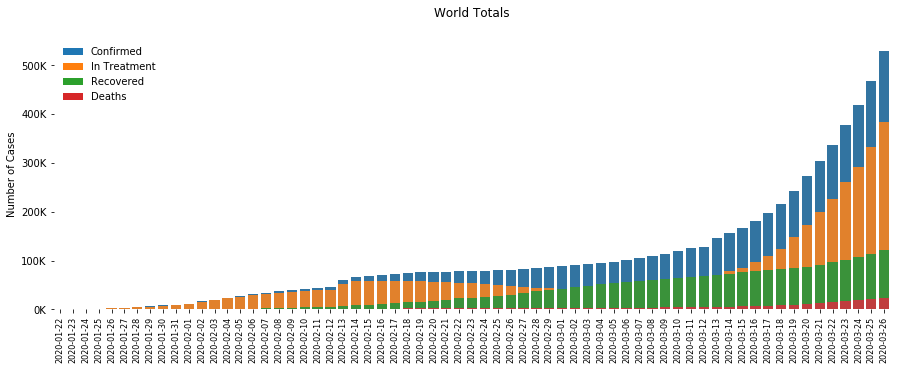

In [13]:
plt.figure(figsize=(15,5))
plt.title('World Totals\n')
sns.barplot(x="Date", y="Confirmed", data=world_count , color = sns.color_palette()[0]);
InTreatment_plot = sns.barplot(x="Date", y="InTreatment", data=world_count , color = sns.color_palette()[1]);
recovered_plot = sns.barplot(x="Date", y="Recovered", data=world_count , color = sns.color_palette()[2]);
deaths_plot = sns.barplot(x="Date", y="Deaths", data=world_count , color = sns.color_palette()[3]);


confirmed = plt.Rectangle((0,0),1,1,fc= sns.color_palette()[0], edgecolor = 'none')
inTreatment = plt.Rectangle((0,0),1,1,fc= sns.color_palette()[1],  edgecolor = 'none')
recovered = plt.Rectangle((0,0),1,1,fc= sns.color_palette()[2],  edgecolor = 'none')
deaths = plt.Rectangle((0,0),1,1,fc= sns.color_palette()[3],  edgecolor = 'none')
legend = plt.legend([confirmed, inTreatment , recovered, deaths], ['Confirmed', 'In Treatment', 'Recovered','Deaths'], loc=2, ncol = 1, prop={'size':10})
legend.draw_frame(False)

sns.despine(left=True, bottom=True)
deaths_plot.set_ylabel("Number of Cases")
deaths_plot.set_xlabel("")
ylabels = ['{:,.0f}'.format(x) + 'K' for x in deaths_plot.get_yticks()/1000]
deaths_plot.set_yticklabels(ylabels)
# deaths_plot.set_xticklabels(world_count['Date'].map(lambda x: str(x.month) +'-'+ str(x.day )),rotation=45);
plt.xticks(rotation=90)
for item in (deaths_plot.get_xticklabels()):
    item.set_fontsize(8)

# Daily Confirmed Growth Factor

/Users/mzoon/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


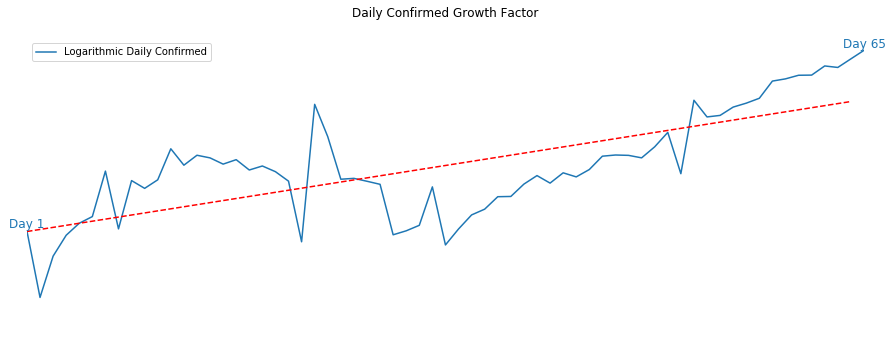

In [14]:
model = sm.OLS(world_count['Log_New_Confirmed'], sm.add_constant(world_count['Days']))
p = model.fit().params
x = np.arange(1, world_count.at[world_count.shape[0]-1, 'Days'])
ax = world_count.plot(x='Days', y='Log_New_Confirmed', kind='line', label='Logarithmic Daily Confirmed', color = sns.color_palette()[0], figsize=(15,5))
ax.axis('off')
ax.plot(x, p.const + p.Days * x, color='red', gid='line 1', linestyle='--');
growth_factor=np.exp(p[1]) 
ax.annotate('Day {}'.format(world_count['Days'][0]),
                (world_count['Days'][0],world_count['Log_New_Confirmed'][0]), 
                va='bottom', ha='center', color = sns.color_palette()[0],size=12)
ax.annotate('Day {}'.format(world_count['Days'][world_count.shape[0]-1]),
                (world_count['Days'][world_count.shape[0]-1],world_count['Log_New_Confirmed'][world_count.shape[0]-1]), 
                va='bottom', ha='center', color = sns.color_palette()[0],size=12)
plt.title('Daily Confirmed Growth Factor\n');


# Daily Confirmed Growth Factor for every week

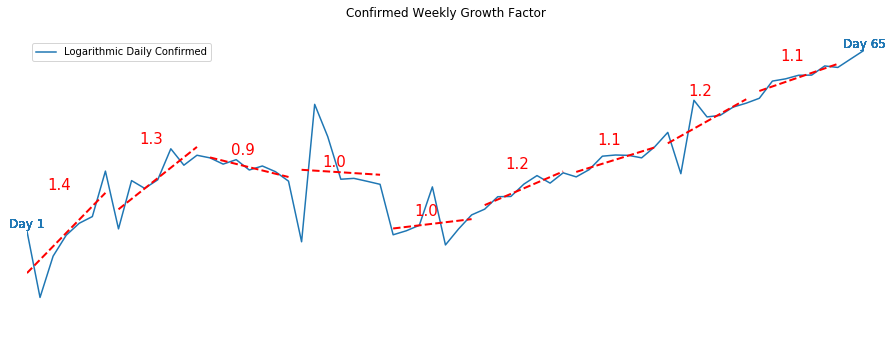

In [15]:
ax = world_count.plot(x='Days', y='Log_New_Confirmed', kind='line', label='Logarithmic Daily Confirmed', color = sns.color_palette()[0], figsize=(15,5))
ax.axis('off')
start=0
end=7

while end <= world_count.shape[0]:
    
    model = sm.OLS(world_count['Log_New_Confirmed'][start:end], sm.add_constant(world_count['Days'][start:end]))
    p = model.fit().params
    x = np.arange(start+1, end+1)
    y = p.const + p.Days * x
    ax.plot(x, y ,color = 'red', linestyle='--', linewidth=2);    
    growth_factor=np.exp(p[1])    
    ax.annotate('{:,.1f}'.format(growth_factor),(end-3.5,y.max()), va='bottom', ha='center',color = 'red',size=15)
    ax.annotate('Day {}'.format(world_count['Days'][0]),
                (world_count['Days'][0],world_count['Log_New_Confirmed'][0]), 
                va='bottom', ha='center', color = sns.color_palette()[0],size=12)
    ax.annotate('Day {}'.format(world_count['Days'][world_count.shape[0]-1]),
                (world_count['Days'][world_count.shape[0]-1],world_count['Log_New_Confirmed'][world_count.shape[0]-1]), 
                va='bottom', ha='center', color = sns.color_palette()[0],size=12)
    
    start+=7
    end+=7
plt.title('Confirmed Weekly Growth Factor\n');

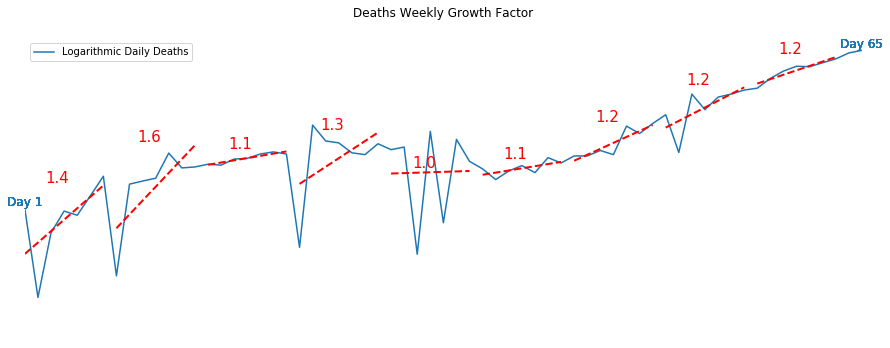

In [16]:
ax = world_count.plot(x='Days', y='Log_New_Deaths', kind='line', label='Logarithmic Daily Deaths', color = sns.color_palette()[0], figsize=(15,5))
ax.axis('off')
start=0
end=7

while end <= world_count.shape[0]:
    
    model = sm.OLS(world_count['Log_New_Deaths'][start:end], sm.add_constant(world_count['Days'][start:end]))
    p = model.fit().params
    x = np.arange(start+1, end+1)
    y = p.const + p.Days * x
    ax.plot(x, y ,color = 'red', linestyle='--', linewidth=2);    
    growth_factor=np.exp(p[1])    
    ax.annotate('{:,.1f}'.format(growth_factor),(end-3.5,y.max()), va='bottom', ha='center',color = 'red',size=15)
    ax.annotate('Day {}'.format(world_count['Days'][0]),
                (world_count['Days'][0],world_count['Log_New_Deaths'][0]), 
                va='bottom', ha='center', color = sns.color_palette()[0],size=12)
    ax.annotate('Day {}'.format(world_count['Days'][world_count.shape[0]-1]),
                (world_count['Days'][world_count.shape[0]-1],world_count['Log_New_Deaths'][world_count.shape[0]-1]), 
                va='bottom', ha='center', color = sns.color_palette()[0],size=12)
    
    start+=7
    end+=7
plt.title('Deaths Weekly Growth Factor\n');

# Growth Factor for each Country For The Last 7 Days

In [17]:
growth_factor_df=pd.DataFrame(columns=['StartDate', 'Country','Deaths_GrowthFactor', 'Confirmed_GrowthFactor'])
for country, country_df in all_country_dict.items():
    
    
    if country_df.shape[0] >= 7 and country_df['New_Deaths'].sum() > 100:

        X = np.arange(country_df.shape[0]-6, country_df.shape[0]+1)
        X = sm.add_constant(X)
        
        y_d = np.log(country_df['New_Deaths'][-7:].astype(int))
        mod_d = sm.OLS(y_d,X)
        result_d = mod_d.fit()
        growth_factor_d = np.exp(result_d.params[1])
        
        y_c = np.log(country_df['New_Confirmed'][-7:].astype(int))
        mod_c = sm.OLS(y_c,X)
        result_c= mod_c.fit()
        growth_factor_c = np.exp(result_c.params[1])
        
        growth_factor_df=growth_factor_df.append({'StartDate' : country_df['Date'][0] , 
                                                  'Country' : country,
                                                  'Deaths_GrowthFactor' : growth_factor_d,
                                                  'Confirmed_GrowthFactor' : growth_factor_c} , ignore_index=True)
        
growth_factor_df = growth_factor_df.sort_values(by='Deaths_GrowthFactor', ascending=False)

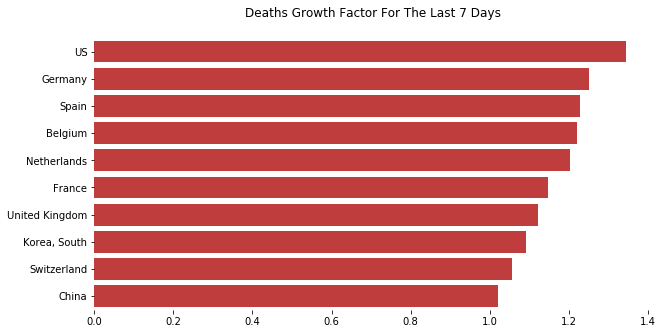

In [18]:
plt.figure(figsize=(10,5))
plt.title('Deaths Growth Factor For The Last 7 Days\n')
mortality_plot = sns.barplot(y="Country", x="Deaths_GrowthFactor", data=growth_factor_df.head(10), color = sns.color_palette()[3]);
sns.despine(left=True, bottom=True)
mortality_plot.set_ylabel("")
mortality_plot.set_xlabel("")
xlabels = ['{:,.1f}'.format(x) for x in mortality_plot.get_xticks()]
mortality_plot.set_xticklabels(xlabels);

In [19]:
growth_factor_df = growth_factor_df.sort_values(by='Confirmed_GrowthFactor', ascending=False)

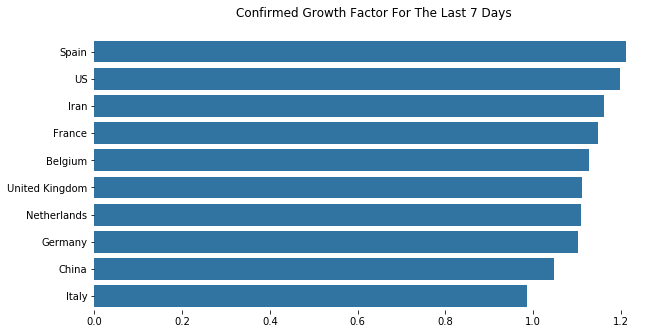

In [20]:
plt.figure(figsize=(10,5))
plt.title('Confirmed Growth Factor For The Last 7 Days\n')
mortality_plot = sns.barplot(y="Country", x="Confirmed_GrowthFactor", data=growth_factor_df.head(10), color = sns.color_palette()[0]);
sns.despine(left=True, bottom=True)
mortality_plot.set_ylabel("")
mortality_plot.set_xlabel("")
xlabels = ['{:,.1f}'.format(x) for x in mortality_plot.get_xticks()]
mortality_plot.set_xticklabels(xlabels);

# World Mortality Rate

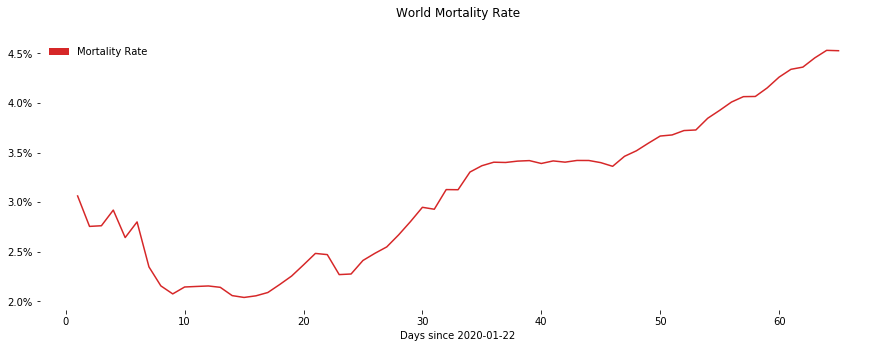

In [21]:
plt.figure(figsize=(15,5))
plt.title('World Mortality Rate\n')

Mortality_plot = sns.lineplot(x="Days", y="MortalityRate", data=world_count , color = sns.color_palette()[3]);

Mortality = plt.Rectangle((0,0),1,1,fc= sns.color_palette()[3],  edgecolor = 'none')
legend = plt.legend([Mortality], ['Mortality Rate'], loc=2, ncol = 1, prop={'size':10})
legend.draw_frame(False)

sns.despine(left=True, bottom=True)
Mortality_plot.set_ylabel("")
Mortality_plot.set_xlabel("Days since 2020-01-22")
ylabels = ['{:,.1f}'.format(x) + '%' for x in Mortality_plot.get_yticks()*100]
Mortality_plot.set_yticklabels(ylabels);

# Current Mortality Rate for each Country

In [22]:
current_mortality_rate=pd.DataFrame(columns=['Country','MortalityRate'])

for country, country_df in all_country_dict.items():
    if country_df.at[country_df.shape[0]-1, 'Confirmed'].astype(int) >= 100:
        current_mortality_rate=current_mortality_rate.append({'Country' :country , 
                                                              'MortalityRate' : country_df.at[country_df.shape[0]-1, 'Deaths'].astype(int) / 
                                                                                country_df.at[country_df.shape[0]-1, 'Confirmed'].astype(int)} , ignore_index=True)
current_mortality_rate=current_mortality_rate.sort_values(by='MortalityRate', ascending=False)

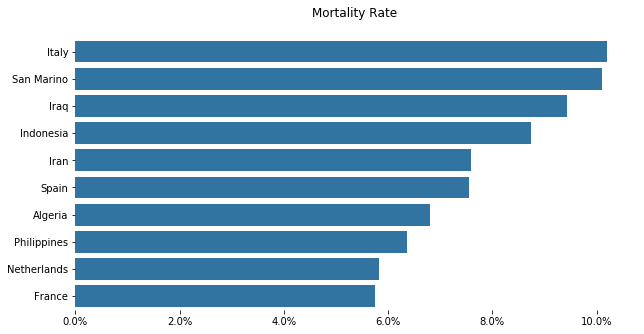

In [23]:
plt.figure(figsize=(10,5))
plt.title('Mortality Rate\n')
mortality_plot = sns.barplot(y="Country", x="MortalityRate", data=current_mortality_rate.head(10), color = sns.color_palette()[0]);
sns.despine(left=True, bottom=True)
mortality_plot.set_ylabel("")
mortality_plot.set_xlabel("")
xlabels = ['{:,.1f}'.format(x) + '%' for x in mortality_plot.get_xticks()*100]
mortality_plot.set_xticklabels(xlabels);

# Deaths lineplot

In [24]:
country_deaths=pd.DataFrame()

for country, country_df in all_country_dict.items():  
       
    if country_df['New_Deaths'].sum() >= 500:
        deaths_df = country_df[country_df['Deaths'] >= 500][['Deaths']].reset_index(drop=True)
        deaths_df.rename(columns={'Deaths': country}, inplace=True)
        country_deaths = pd.concat([country_deaths, deaths_df], axis=1, sort=False)

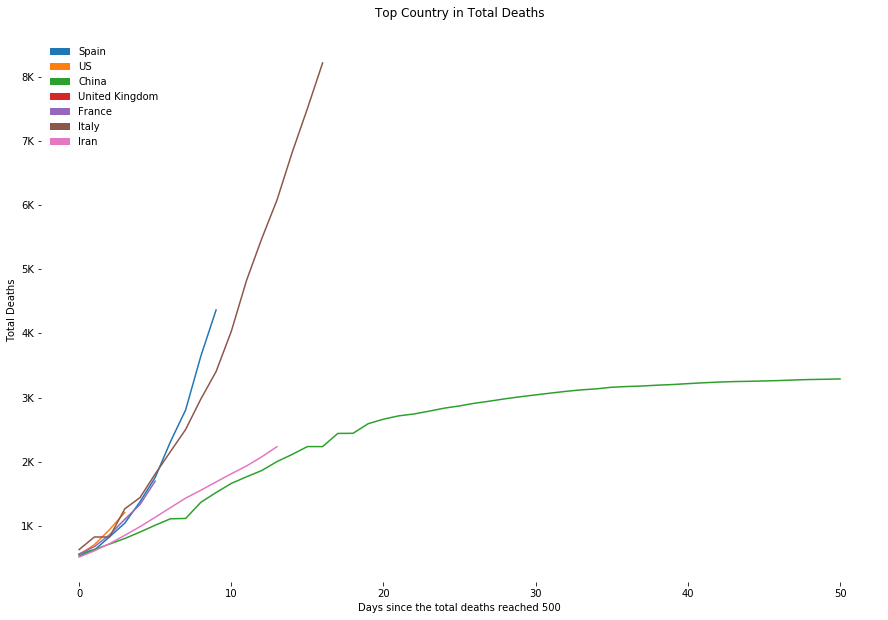

In [25]:
plt.figure(figsize=(15,10))
plt.title('Top Country in Total Deaths\n')

legend_list=[]
legend_lable=[]

for i, country in enumerate(country_deaths.columns):   

    plot_= sns.lineplot(x=country_deaths.index, y=country, data=country_deaths, color= sns.color_palette()[i]);

    legend_list.append(plt.Rectangle((0,0),1,1,fc= sns.color_palette()[i],  edgecolor = 'none'))
    legend_lable.append(country)
    sns.despine(left=True, bottom=True)

legend = plt.legend(legend_list, legend_lable, loc=2, ncol = 1, prop={'size':10})
legend.draw_frame(False)

plot_.set_ylabel("Total Deaths")
plot_.set_xlabel("Days since the total deaths reached 500")
ylabels = ['{:,.0f}'.format(x) + 'K' for x in plot_.get_yticks()/1000]
plot_.set_yticklabels(ylabels);

# Total Deaths per Million

In [26]:
import geopandas
import descartes

In [27]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
population = pd.read_csv('world_population.csv')
population.rename(columns={'Country Code': 'iso_a3'}, inplace=True)
population = population[['iso_a3','Population']]

In [28]:
world.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 6 columns):
pop_est       177 non-null int64
continent     177 non-null object
name          177 non-null object
iso_a3        177 non-null object
gdp_md_est    177 non-null float64
geometry      177 non-null geometry
dtypes: float64(1), geometry(1), int64(1), object(3)
memory usage: 8.4+ KB


In [29]:
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 2 columns):
iso_a3        264 non-null object
Population    262 non-null float64
dtypes: float64(1), object(1)
memory usage: 4.2+ KB


In [30]:
world.loc[world.name == 'France', 'iso_a3'] = "FRA"
world.loc[world.name == 'Norway', 'iso_a3'] = "NOR"

In [31]:
world = pd.merge(world, population, on='iso_a3', how='left')

In [32]:
by_country=pd.DataFrame(columns=['name','Deaths','Confirmed'])
for country, country_df in all_country_dict.items():
    by_country=by_country.append({'name' : country,
                                  'Deaths' : country_df['New_Deaths'].sum(),
                                  'Confirmed' : country_df['New_Confirmed'].sum()} , ignore_index=True)
        
by_country = by_country.astype({'Deaths':int})

In [33]:
death_by_country = by_country[by_country['Deaths'] >= 5][['name','Deaths']]

In [34]:
map_world= list(world['name'])
country_name= list(death_by_country['name'])

In [35]:
missing=[]
for mis in country_name:
    if mis not in map_world:
        missing.append(mis)

missing

['US', 'Dominican Republic', 'Korea, South', 'Diamond Princess', 'San Marino']

In [36]:
death_by_country.loc[death_by_country.name == 'US', 'name'] = "United States of America"
death_by_country.loc[death_by_country.name == 'Korea, South', 'name'] = "South Korea"
death_by_country.loc[death_by_country.name == 'Dominican Republic', 'name'] = "Dominican Rep."

In [37]:
world = pd.merge(world, death_by_country, on='name', how='left')

In [38]:
world['Death_per_m']= world['Deaths'] * 1000000 / world['Population']
world = world[(world.name!="Antarctica")]

/Users/mzoon/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


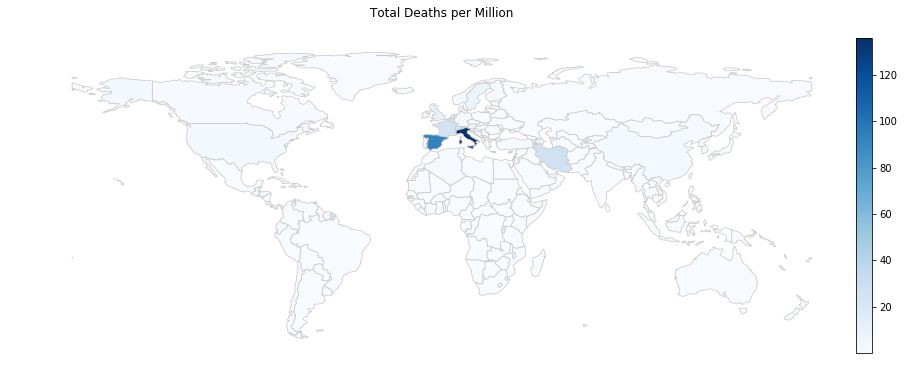

In [39]:
fig, ax = plt.subplots(1, figsize=(15, 10))
plt.title('Total Deaths per Million\n')
ax.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
world.plot(column='Death_per_m', 
           cmap='Blues', 
           ax=ax,
           cax=cax,
           legend=True, 
#            legend_kwds={'label': "Death per Million"},
           linewidth=0.8,
           edgecolor='0.8');


# All Country Daily Confirmed lineplot

In [40]:
for country, country_df in all_country_dict.items():    
    all_country_dict[country]= df_country.set_index(df_country['Date'], drop=True)

In [41]:
all_country_dict={}
for Country in set(all_data_dict[dates_list[-1]]['Country/Region']): 

    df_country = pd.DataFrame(columns=['Confirmed', 'Recovered', 'Deaths', 'LastUpdate','Date'])

    for date, data_df in all_data_dict.items():
        if Country in list(data_df['Country/Region']):
            dfTpm = data_df.groupby(['Country/Region']).agg({'Confirmed':np.sum, 
                                                             'Recovered':np.sum, 
                                                             'Deaths':np.sum, 
                                                             'LastUpdate':'first',
                                                             'Date':'first'})
            
            df_country = df_country.append(dfTpm.loc[Country, :])        

    df_country=df_country.reset_index(drop=True)
    
    df_country['New_Confirmed']=df_country['Confirmed'].diff()
    df_country.at[0, 'New_Confirmed'] = df_country['Confirmed'][0]
    df_country['New_Deaths']=df_country['Deaths'].diff()
    df_country.at[0, 'New_Deaths'] = df_country['Deaths'][0]

    df_country = df_country.astype({'New_Confirmed':int, 'Confirmed':int, 'Deaths':int, 'Recovered':int, 'New_Deaths':int})
    df_country.set_index(df_country['Date'], drop=True, inplace=True)
    all_country_dict[Country]= df_country

In [42]:
country_new=pd.DataFrame(index=pd.to_datetime(all_country_dict['China'].Date))

for country, country_df in all_country_dict.items():    
            
    new_df = country_df[['New_Confirmed']]
    new_df.rename(columns={'New_Confirmed': country}, inplace=True)
    country_new = pd.concat([country_new, new_df], axis=1, sort=False)
        
country_new.fillna(0, inplace=True)
country_new = country_new.astype(int)

/Users/mzoon/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [43]:
# Only include coutries have cases more than 50
# country_new_100 = country_new[[i for i in country_new.columns if country_new[i].sum()>100]]

In [44]:
# len(country_new_100)

In [45]:
country_list= list(by_country[['name','Confirmed']].sort_values(by='Confirmed', ascending=False)['name'])[:63]
country_new_100 = country_new[country_list]

In [46]:
# Square root transformation
country_new_100_Trans = country_new_100**0.5

In [47]:
# Normalisation column-wise
from sklearn import preprocessing

x = country_new_100_Trans.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
country_new_100_Norm = pd.DataFrame(x_scaled)
country_new_100_Norm.columns = country_new_100.columns

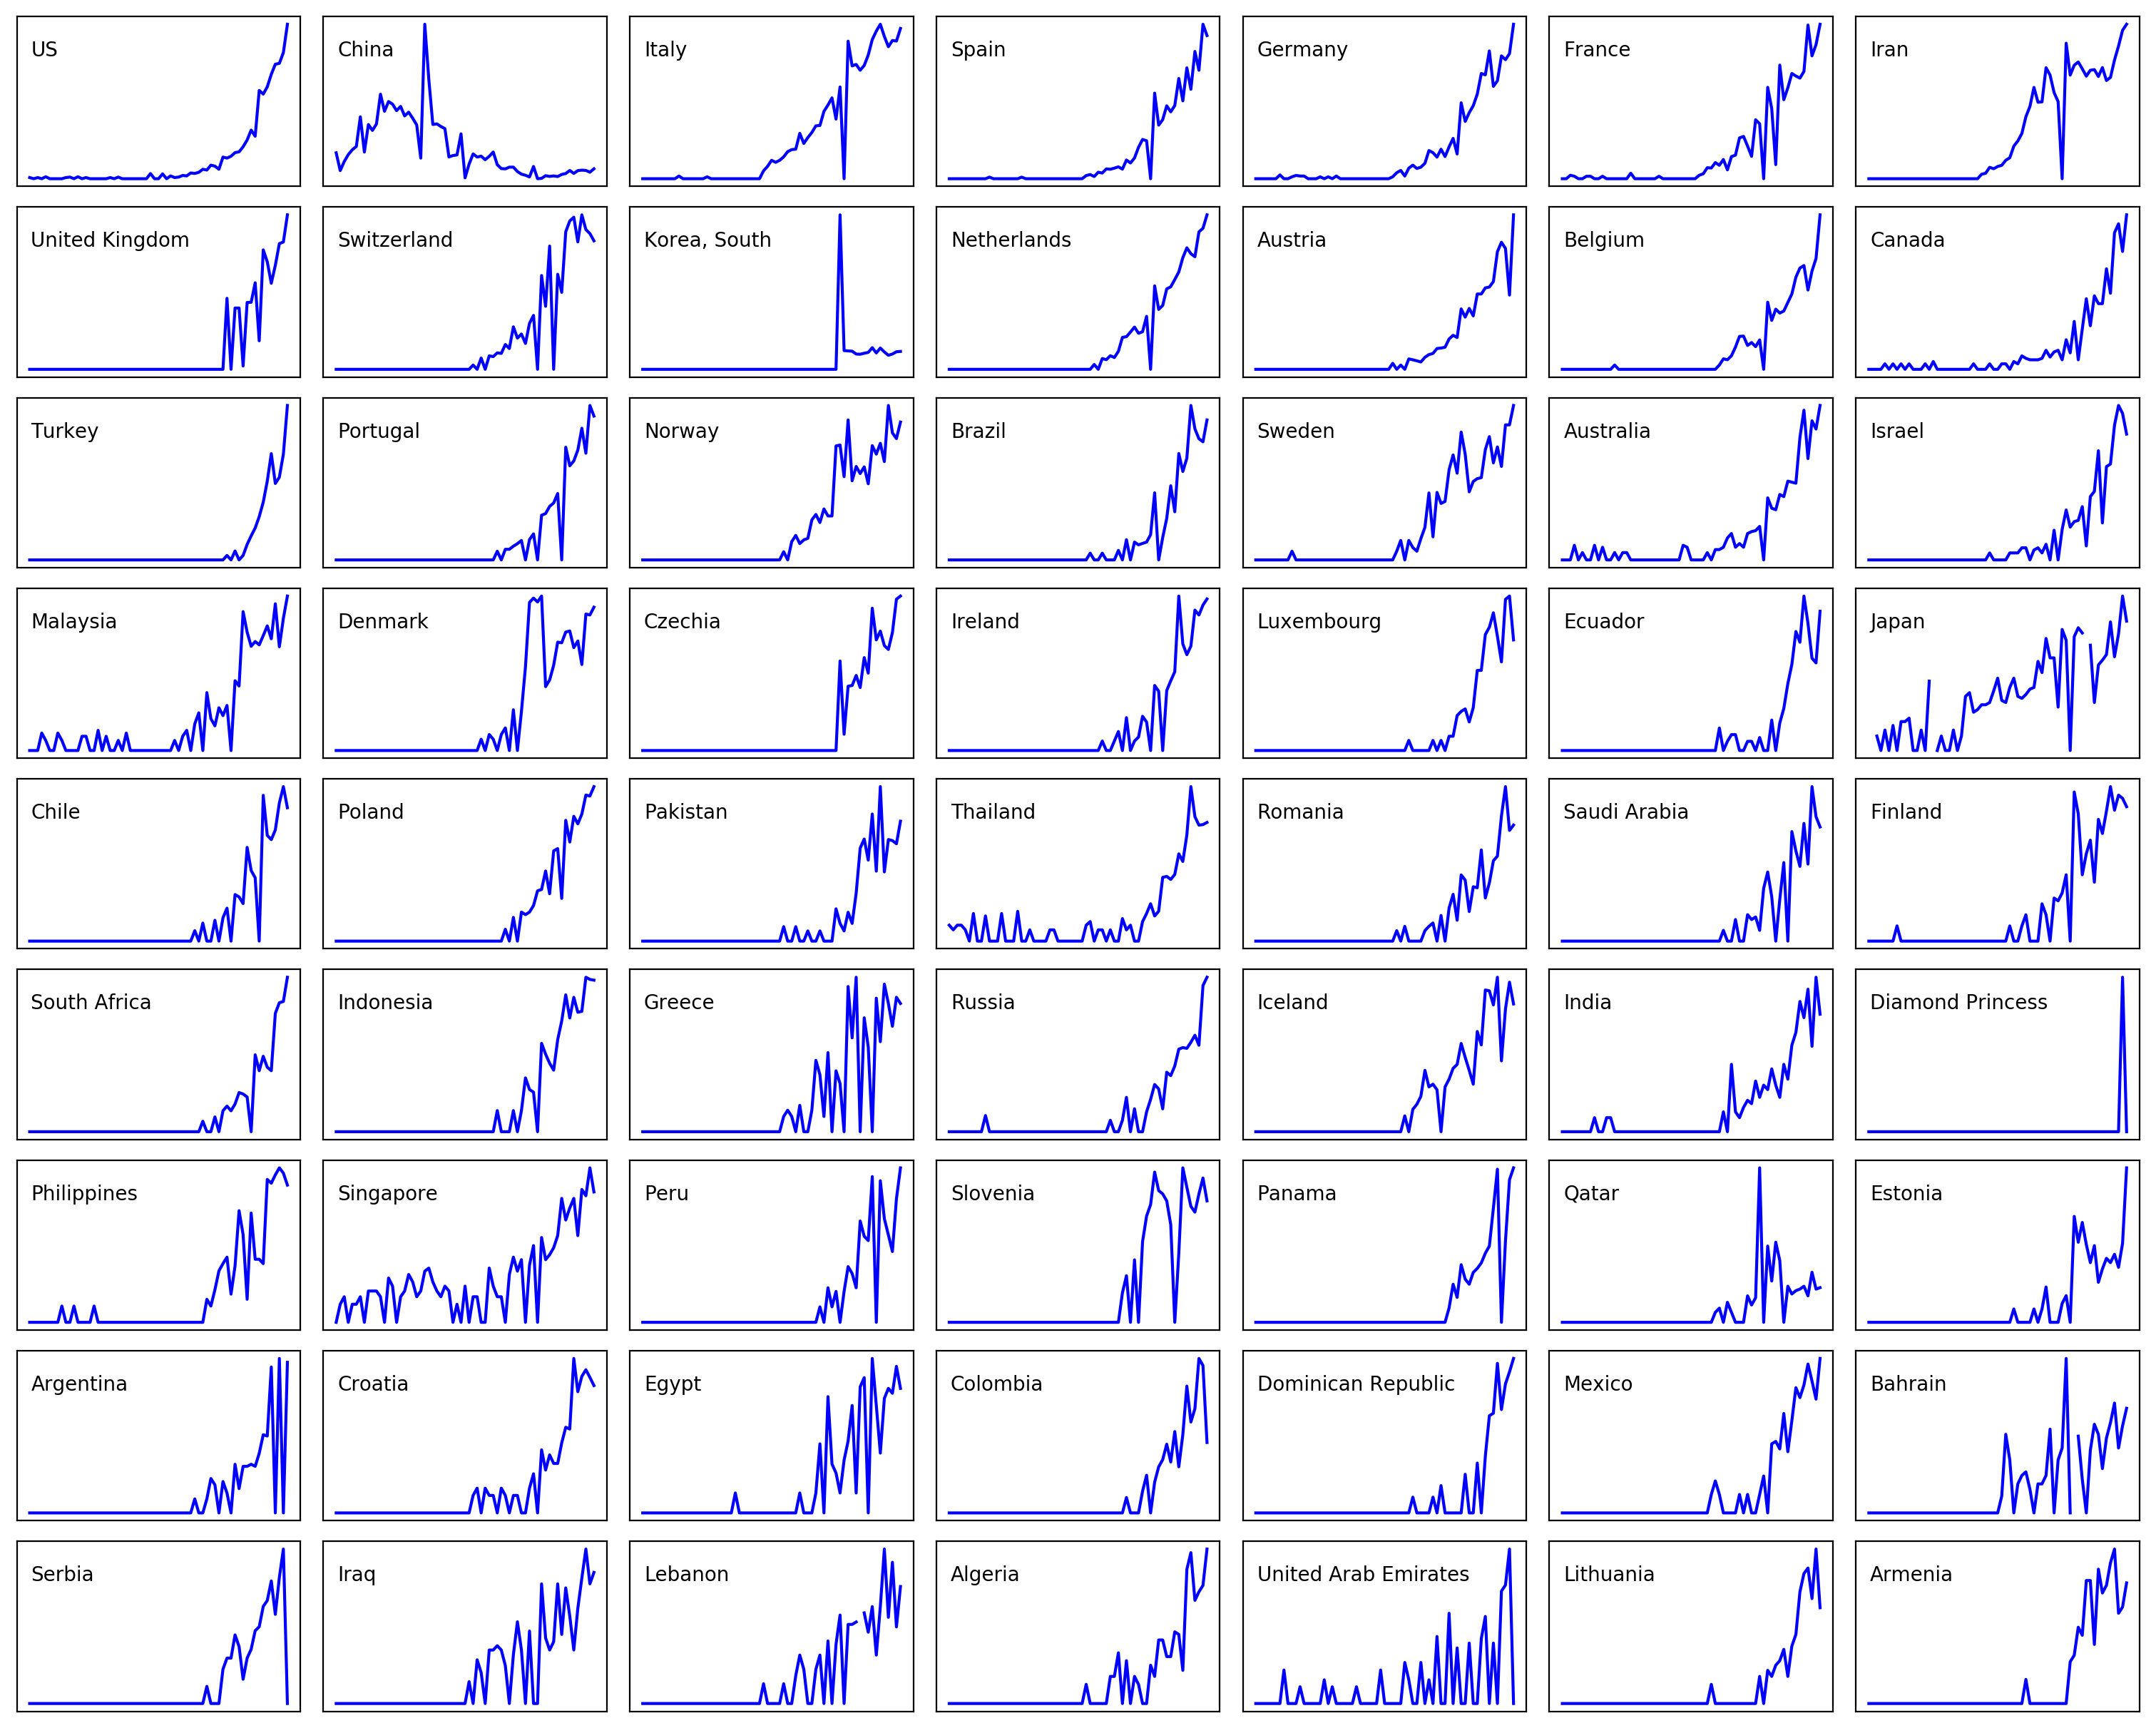

In [48]:
fig = plt.figure(figsize=(15,12), dpi=200, constrained_layout=True)

axs = fig.subplots(nrows=9, ncols=7)

for i in range(len(country_new_100_Norm.columns)):
    axs.flat[i].plot(country_new_100_Norm.index, country_new_100_Norm.iloc[:,i], color='blue')
    axs.flat[i].get_xaxis().set_ticks([])
    axs.flat[i].get_yaxis().set_ticks([])
    axs.flat[i].annotate(country_new_100_Norm.iloc[:,i].name, (0.05, 0.8),xycoords='axes fraction', va='center', ha='left')